# Transition States

In this exercise, we will study the SN$_2$ reaction between Cl$^-$ and CH$_3$Cl involving a Walden inversion. This exercise is based on Lab 7 of [Computational Chemistry for Chemistry Educators](http://www.computationalscience.org/ccce/about/labs/labs.php).

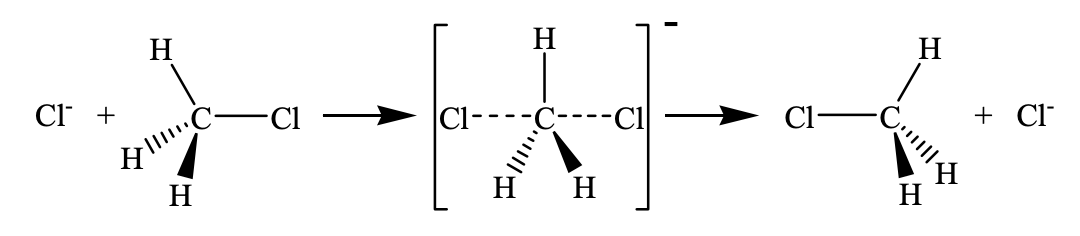

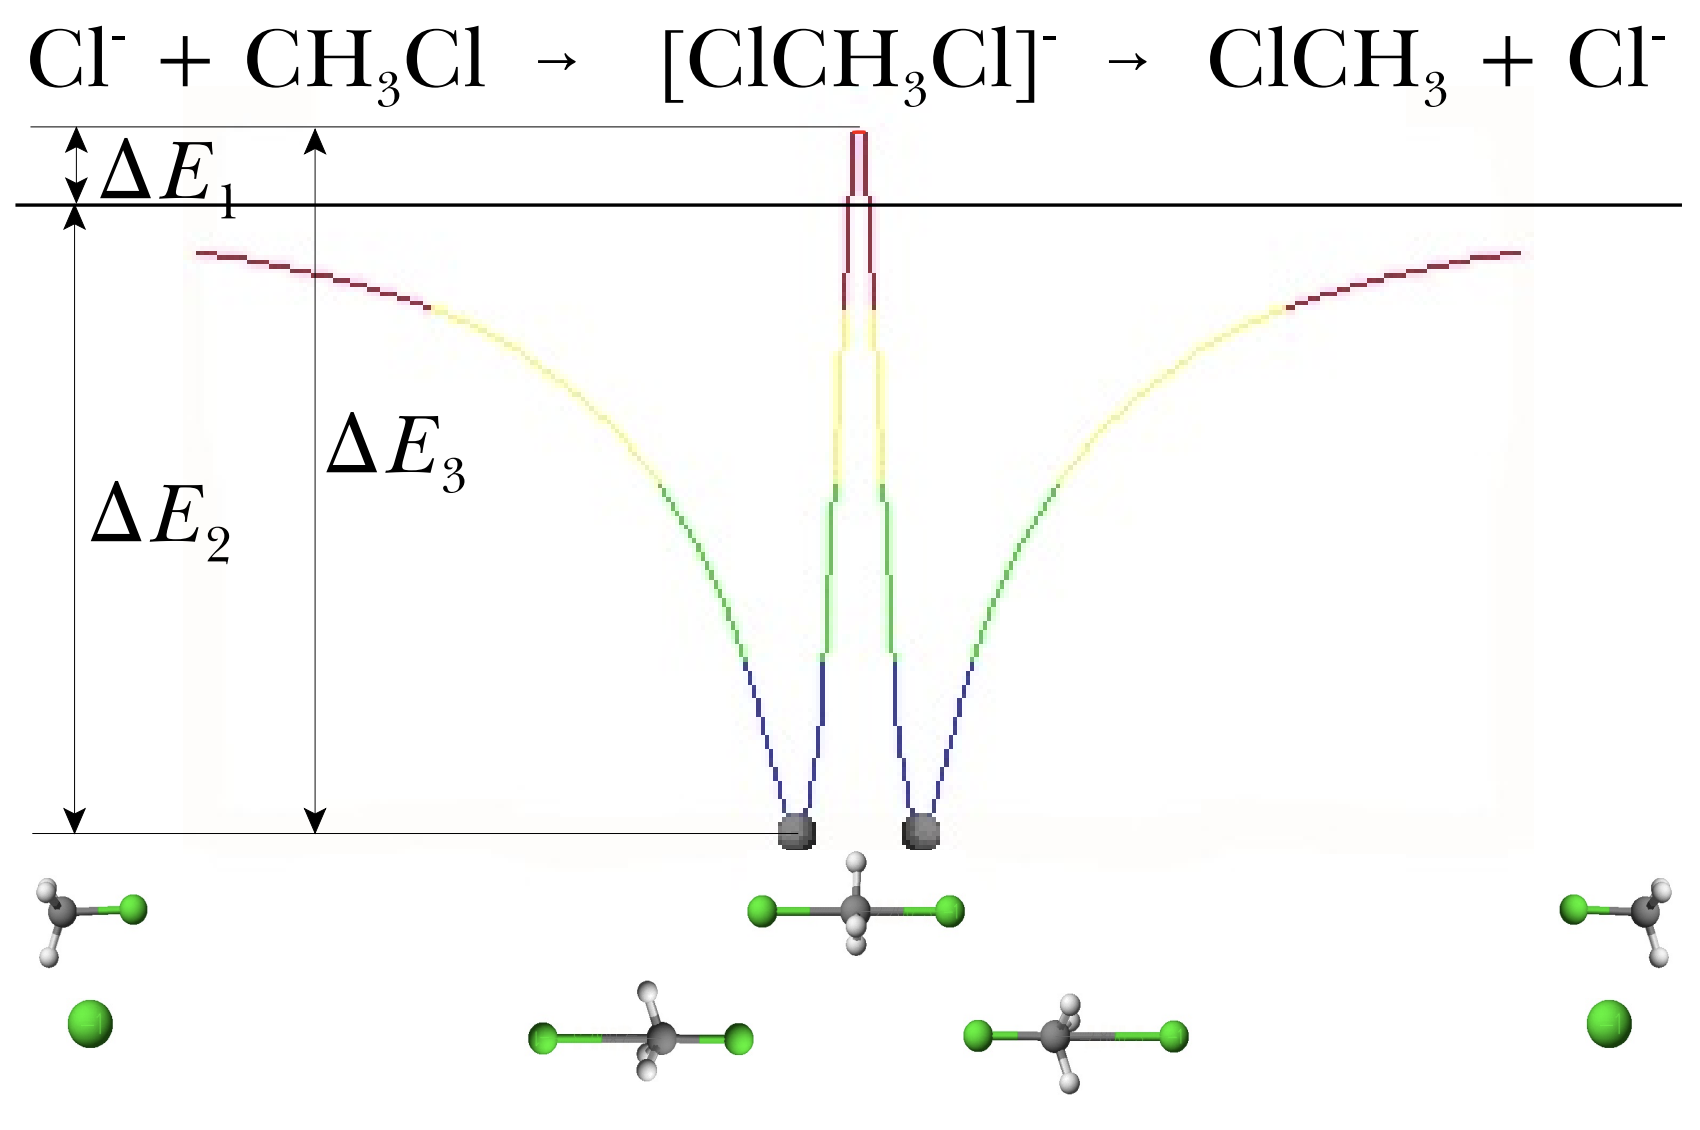

# Part 0 - Setting up the appropriate software

In [ ]:
#@title Install packages with pip
#@markdown pyscf (Python-based Simulations of Chemistry Framework), for QM electronic structure calculation \\
#@markdown jsme_notebook, to sketch structures \\
#@markdown pyberny, for optimization \\
#@markdown geometric, for optimization \\
#@markdown condacolab, to install other packages \\
#@markdown
#@markdown Installing condacolab will restart the kernel and you can continue with the next cell.

!pip install pyscf
!pip install git+https://github.com/pyscf/semiempirical
!pip install -U pyberny
!pip install geometric
!pip install jsme_notebook

try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [ ]:
#@title Install packages with conda
#@markdown rdkit, to generate initial structures from SMILES strings \\
#@markdown py3Dmol, for visualization of structures \\

try:
    import condacolab
    condacolab.check()
    !mamba install --yes -c conda-forge rdkit py3Dmol
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import rdkit
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

In [ ]:
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem

from pyscf import gto, scf, dft
from pyscf.geomopt.berny_solver import optimize

import py3Dmol

import ipywidgets as widgets
from ipywidgets import interact

# SMILES string tool

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

# Part 1 - Building an initial model

After building a model from the SMILES string, we will orient it so that the carbon is at the origin and one chlorine is on a x axis.

In [ ]:
# Build and optimize the structure of CH_3Cl
smiles = 'CCl'

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

conformer = rdkit_mol.GetConformer()
# Make the principal axes about the centroid coincide with x, y, and z
Chem.rdMolTransforms.CanonicalizeConformer(conformer)
# Move the carbon to the origin
positions = conformer.GetPositions()
conformer.SetPositions(positions - positions[0])

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Manually add another chlorine
xyz = f'Cl {-5:12.6f}{0:12.6f}{0:12.6f}\n' \
  + Chem.MolToXYZBlock(rdkit_mol)[3:]
print(xyz)

# Part 2 - Potential energy scan

Now we will do a constrained minimization at different C-Cl distances.

--> Based on the [geomeTRIC documentation](https://geometric.readthedocs.io/en/latest/constraints.html), modify the code below to freeze the carbon (atom index 1) at the origin and the initially bonded chlorine (atom index 2) to the x axis.

In [ ]:
# Define molecule and basis set
gto_mol = gto.Mole() # Gaussian-type orbitals
# Add Chlorine and set a net negative charge
gto_mol.atom = xyz
gto_mol.charge = -1
gto_mol.verbose = False
gto_mol.basis = '3-21g*'
gto_mol.build()
mf = scf.RHF(gto_mol).run()

energies = []
structures = []

distances = sorted(np.linspace(1.5,5,36), reverse=True)
for distance in distances:
  # Set the distance,
  # freeze the carbon, and
  # freeze the y and z position of the initially bonded chlorine
  with open('constraints.txt','w') as F:
    F.write(f"""$set
distance 1 2 {distance}
$freeze
xyz 4""")
  mol_eq = mf.Gradients().optimizer(solver='geomeTRIC').kernel(\
   {"constraints": "constraints.txt",})
  mf.mol.set_geom_(mol_eq.atom_coords(unit='Angstrom'), unit='Angstrom')
  energies.append(scf.RHF(mol_eq).run().e_tot)
  structures.append(mol_eq.tostring('xyz'))

In [ ]:
# This code visualizes the geometry at every distance
view = py3Dmol.view()
view.addModelsAsFrames('\n'.join(structures),'xyz')
view.setStyle({'model':0}, {'sphere': {}})
view.zoomTo()
view.animate({'loop': "backAndForth"})
view.show()

In [ ]:
# This code shows the energy and distance of the initially bonded Cl
# as a function of the distance of the added Cl
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(distances, energies)
axs[0].set_ylabel('Energy (Hartrees)');

x_Cl = [float(structure.split('\n')[4].split()[1]) for structure in structures]
axs[1].plot(distances, x_Cl);
axs[1].plot([2, 3], [2, 3], '--');
axs[1].set_ylabel('Initial Cl x position (A)');
axs[1].set_xlabel('Cl-C distance (A)');


In [ ]:
# This code prints a table of the same information
print('Index\tD1\tEnergy\t\tD2')
for index, (distance, energy, x) in enumerate(zip(distances, energies, x_Cl)):
  print(f'{index}\t{distance:.2f}\t{energy:.3f}\t{x:.3f}')

--> What is the C-Cl bond distance closest to the saddle point of the potential energy surface? What is the energy of the system?

Distance: X Å (Lit. value 2.38 Å). Energy: X kcal/mol.

--> What is the energy of one of the minima?

Energy: X kcal/mol.

--> What is the height of the energy barrier?

Energy: X kcal/mol (Lit val. 13 ± 2 kcal/mol).

# Part 3 - Optimizing and visualizing the transition state

The potential energy scan gives us a structure that is close to the transition state, but not precisely. According to the [geomeTRIC documentation](https://geometric.readthedocs.io/en/latest/transition.html), "A transition state (TS) is an energy maximum along a reaction pathway that connects reactant and product structures. It is a critical point on the potential energy surface (PES) characterized by one negative eigenvalue in the Hessian matrix that corresponds to a vibrational mode along which the PES is concave down. The TS is essential to theoretical estimates of reaction rates and testing of mechanistic hypotheses due to the exponential decay of the reaction rate with increasing activation energy (the energy difference between the TS and reactant structures)." We will use a structure from the potential energy scan as a starting point for finding a transition state structure.

--> Define `ts_index` to be the index of a structure that is close to the transition state.

In [ ]:
ts_index = 2
positions = np.array([[float(l) for l in line.split()[1:]] \
             for line in structures[ts_index].split('\n')[2:]])
mf.mol.set_geom_(positions, unit='Angstrom')
mol_eq = mf.Gradients().optimizer(solver='geomeTRIC').kernel(\
  {'transition': True})

The code below visualizes the transition state with an isosurface for the density colored by the electrostatic potential. The positions of atoms themselves are shown as spheres.

In [ ]:
# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.density(mol_eq, 'density.cube', \
  mf.make_rdm1(), resolution=resolution); # density
cubegen.mep(mol_eq, 'mep.cube', \
  mf.make_rdm1(), resolution=resolution); # molecular electrostatic potential

# Read volumetric data
vol = {}
for data_type in ['density','mep']:
  vol[data_type] = open(data_type + ".cube", "r").read()

# Show isosurface of the electron density, colored by electrostatic potential
v = py3Dmol.view()
v.addVolumetricData(vol['density'], "cube", {'isoval': 0.01, 'opacity':.8,
            'voldata': vol['mep'], 'volformat': 'cube',
            'volscheme': {'gradient':'rwb', 'min':-.1, 'max':.1}});
v.addModel(mol_eq.tostring('xyz'), 'xyz')
# v.setStyle({'stick':{}})
v.setStyle({'sphere':{'radius':0.2}})
v.zoomTo()
v.show()

--> Describe the geometry of the system.